# Calibrating a Leapfrog ADC

This is an example notebook to show the general calibration workflow when using the cbadc toolbox.

In [1]:
import cbadc
import os
import datetime
from scipy.signal import firwin2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2023-11-03 12:55:44.071730: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 12:55:44.098980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 12:55:44.099010: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 12:55:44.099039: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 12:55:44.104713: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 12:55:44.105171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

### The Leapfrog Analog Frontend

We start by parametrizing a leapfrog ADC

In [2]:
N = 10
BW = 1e6
ENOB = 20
kappa_0 = 0.5

In [3]:
analog_frontend = cbadc.synthesis.get_leap_frog(N=N, BW=BW, ENOB=ENOB)

The leapfrog synthesis fixes the control period such that we now can define

In [4]:
T = analog_frontend.digital_control.clock.T
OSR = 1.0 / (2.0 * BW * T)
print(f"T={T:.2e}, OSR={OSR:0.1f}")

T=4.94e-08, OSR=10.1


We extend the analog frontend to also accommodate a reference single sequence.

In [5]:
Gamma = np.hstack(
    (
        kappa_0 * analog_frontend.analog_system.Gamma[:, :1],
        analog_frontend.analog_system.Gamma,
    )
)
extended_analog_system = cbadc.analog_system.AnalogSystem(
    analog_frontend.analog_system.A,
    analog_frontend.analog_system.B,
    analog_frontend.analog_system.CT,
    Gamma,
    analog_frontend.analog_system.Gamma_tildeT,
)
extended_digital_control = cbadc.digital_control.DitherControl(
    1, analog_frontend.digital_control
)
extended_analog_frontend = cbadc.analog_frontend.AnalogFrontend(
    extended_analog_system, extended_digital_control
)

The resulting analog system and digital control are of the form

In [6]:
print(extended_analog_system)

The analog system is parameterized as:
A =
[[ 0.00e+00  9.76e+05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
   0.00e+00  0.00e+00  0.00e+00]
 [-1.01e+07  0.00e+00  9.76e+05  0.00e+00  0.00e+00  0.00e+00  0.00e+00
   0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -1.01e+07  0.00e+00  9.76e+05  0.00e+00  0.00e+00  0.00e+00
   0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00 -1.01e+07  0.00e+00  9.76e+05  0.00e+00  0.00e+00
   0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00 -1.01e+07  0.00e+00  9.76e+05  0.00e+00
   0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.01e+07  0.00e+00  9.76e+05
   0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.01e+07  0.00e+00
   9.76e+05  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.01e+07
   0.00e+00  9.76e+05  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  -1.01e+07  0.00e+00  9.76e+05]
 [ 0.00e+00 

In [7]:
print(extended_digital_control)


The Digital Control is parameterized as:

--------------------------------------------------------------------------------

clock:
Clock(T=4.9422082723204166e-08, tt=1e-14, td=0.0, duty_cycle=0.5, max_swing=2.0)

M:
11
        


## Behavioral Simulation

Next we simulate the analog frontend both with and without input signal.
The simulation parameters are defined as

In [8]:
amplitude = 1.0 - kappa_0
# To ensure coherent sampling
frequency = 1.0 / T
while frequency > BW:
    frequency /= 2
phase = 0.0
offset = 0.0
input_signal = cbadc.analog_signal.Sinusoidal(amplitude, frequency, phase, offset)


The training and testing simulators and data arrays are then initialized

In [9]:
training_data_size = 1 << 16
training_control_signals = np.zeros((training_data_size, extended_digital_control.M))
training_simulator = cbadc.simulator.PreComputedControlSignalsSimulator(
    extended_analog_system,
    extended_digital_control,
    # no input
    [],
    initial_state_vector=np.random.normal(0.0, 0.1, (extended_analog_system.N)),
)

INFO:cbadc.simulator.numerical_simulator:Executing pre-computations.


In [10]:
testing_data_size = 1 << 12
testing_control_signals = np.zeros((testing_data_size, extended_digital_control.M))
testing_simulator = cbadc.simulator.PreComputedControlSignalsSimulator(
    extended_analog_system,
    extended_digital_control,
    [input_signal],
)

INFO:cbadc.simulator.numerical_simulator:Executing pre-computations.


Next follows the acctual training and testing simulations

In [11]:
for index in cbadc.utilities.show_status(range(training_data_size)):
    training_control_signals[index, :] = next(training_simulator)

100%|██████████| 65536/65536 [00:16<00:00, 4032.52it/s]


In [12]:
for index in cbadc.utilities.show_status(range(testing_data_size)):
    testing_control_signals[index, :] = next(testing_simulator)

100%|██████████| 4096/4096 [00:03<00:00, 1278.56it/s]


## Digital Estimator

It's now time to calibrate and later validate the digital estimator.

First, we define a reference filter and instantiate the filters

In [13]:
# Number of filter taps
K = 1 << 10
reference_filter = -kappa_0 * firwin2(
    K,
    np.array(
        [
            0.0,
            0.9 / OSR,
            1.1 / OSR,
            1.0
        ]
    ),
    np.array(
        [1.0, 1.0, 0.0, 0.0]
    ),
).reshape((1, K))

In [14]:
digital_estimator = cbadc.digital_estimator.AdaptiveFIRFilter()

2023-11-03 12:56:11.452556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 12:56:11.490067: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


We define a Keras optimizer and compile our digital estimator model with a loss function

In [15]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=1e-3,
    momentum=0.9,
    nesterov=True,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name="SGD",
)

In [16]:
digital_estimator.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.MeanSquaredError(),
)

### Calibration

The calibration follows from the standard Keras fit API.

However, first we need to convert our control signals into a compatible shape and form and define our training parameters

In [17]:
training_features, training_labels = digital_estimator.generate_dataset(training_control_signals, reference_filter)

INFO:cbadc.digital_estimator.adaptive_filter:sizeof incoming data 5.5 MB
INFO:cbadc.digital_estimator.adaptive_filter:sizeof outgoing training features 630.0 MB
INFO:cbadc.digital_estimator.adaptive_filter:sizeof outgoing training labels 0.4921875 MB


In [18]:
batch_size = 1 << 7
epochs = 1 << 9

# this is convenient for observing the training progress in tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [19]:
digital_estimator.fit(
    x=training_features,
    y=training_labels,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0,
    callbacks=[tensorboard_callback],
)

After calibration we can print the model summary and save the filter for later use

In [20]:
print(digital_estimator.summary())
digital_estimator.save('de.keras')

Model: "adaptive_fir_filter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  10241     
                                                                 
Total params: 10241 (80.01 KB)
Trainable params: 10241 (80.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


This allows us to reload an already calibrated digital estimator for further calibration or processing

In [21]:
digital_estimator = tf.keras.models.load_model('de.keras')

In the [AdaptiveFirFilter]() class there are some convenience functions to access the resulting filter and visualize it

In [22]:
h, offset = digital_estimator.get_filters(N)

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'impulse responses'}, ylabel='$h[.]$'>,
        <Axes: xlabel='filter taps', ylabel='$|h[.]|$'>], dtype=object))

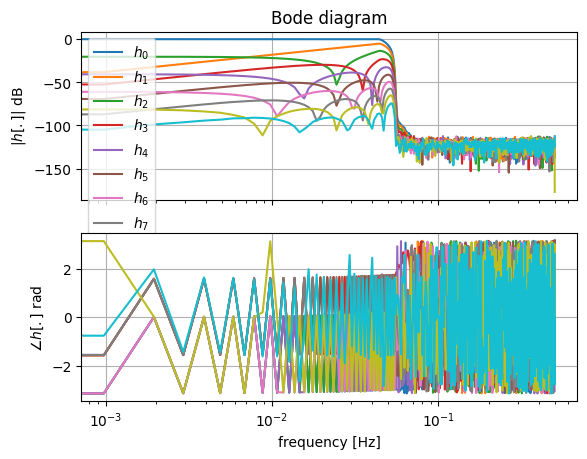

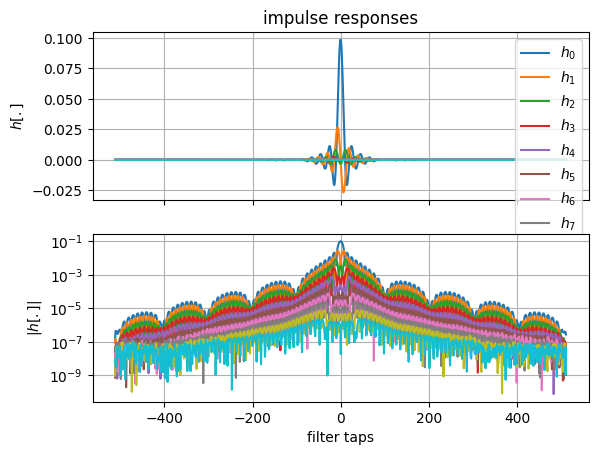

In [23]:
digital_estimator.plot_bode(N)
digital_estimator.plot_impulse_response(N)

### Validating the Estimator

To validate the digital estimator there are two options, using the Keras API predict or alternativley the predict_full.
The following two operations are identical

In [24]:
testing_features, testing_labels = digital_estimator.generate_dataset(testing_control_signals, reference_filter)
# u_hat = digital_estimator.predict(testing_features) - testing_labels
u_hat = digital_estimator.predict_full(testing_features, testing_labels)

INFO:cbadc.digital_estimator.adaptive_filter:sizeof incoming data 0.34375 MB
INFO:cbadc.digital_estimator.adaptive_filter:sizeof outgoing training features 30.0 MB
INFO:cbadc.digital_estimator.adaptive_filter:sizeof outgoing training labels 0.0234375 MB


96/96 [==============================] - 0s 767us/step


Additionally, we can compute the calibration error as

In [25]:
training_error = digital_estimator.predict_full(training_features, training_labels)

2016/2016 [==============================] - 1s 671us/step


### Visualize the Final Estimate

The final estimate can be seen in time and frequency as

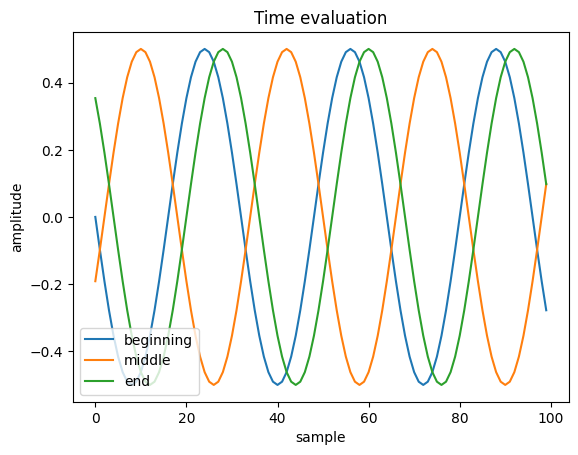

In [26]:
time_plot = plt.figure()
time_axis = time_plot.add_subplot(111)
time_axis.set_title("Time evaluation")
time_axis.set_xlabel("sample")
time_axis.set_ylabel("amplitude")
time_axis.plot(np.arange(u_hat[0:100].size), u_hat[:100], label="beginning")
time_axis.plot(
    np.arange(u_hat[u_hat.size // 2 - 50 : u_hat.size // 2 + 50].size),
    u_hat[u_hat.size // 2 - 50 : u_hat.size // 2 + 50],
    label="middle",
)
time_axis.plot(np.arange(u_hat[-100:].size), u_hat[-100:], label="end")
time_axis.legend(loc="lower left")
plt.show()

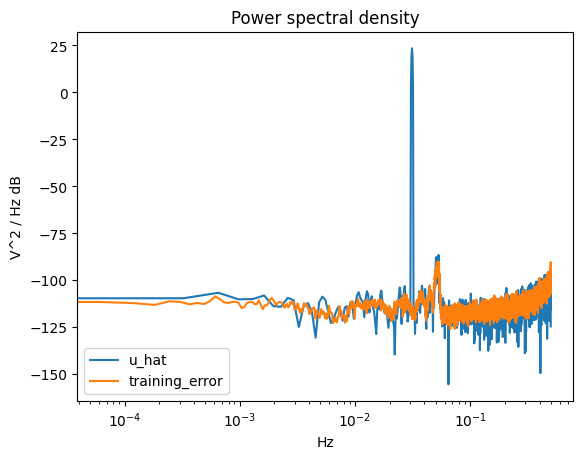

In [27]:
psd_plot = plt.figure()
psd_axis = psd_plot.add_subplot(111)
psd_axis.set_title("Power spectral density")
psd_axis.set_xlabel("Hz")
psd_axis.set_ylabel("V^2 / Hz dB")

f_u_hat, psd_u_hat = cbadc.utilities.compute_power_spectral_density(
    u_hat,
)
psd_axis.semilogx(
    f_u_hat,
    10 * np.log10(np.abs(psd_u_hat)),
    label="u_hat",
)


f_training, psd_training = cbadc.utilities.compute_power_spectral_density(
    training_error,
)
psd_axis.semilogx(
    f_training,
    10 * np.log10(np.abs(psd_training)),
    label="training_error",
)

psd_axis.legend(loc="lower left")